In [ ]:
!pip install kagglehub


In [ ]:
# !pip install tensorflow

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
BASE_DIR = path
# SOURCE_DIR = "/kaggle/working"

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs ,outputs = model.layers[-2].output)
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Now we will be loading the image and preprocess it
features = {}
image_dir = os.path.join(BASE_DIR , "Images")
image_list = sorted(os.listdir(image_dir))[:100]  ## this sorted method was used because listdir list the directories in random order
for img_name in tqdm(image_list):
  img_path = os.path.join(image_dir , img_name)
  img = load_img(img_path , target_size=(224,224))
  img = img_to_array(img)
  # reshape data for model
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2])) ### here 1 represents batch_size , it's 1 image at a time so 1
  img = preprocess_input(img)
  ## extract features
  feature = model.predict(img)
  image_id = img_name.split('.')[0]
  features[image_id] = feature



  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974

In [ ]:
features

{'1000268201_693b08cb0e': array([[2.5074728, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.       , 0.       , 0.4941473, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.4937918 , 0.        , 0.53567505, ..., 2.315237  , 3.7418265 ,
         0.        ]], dtype=float32),
 '1003163366_44323f5815': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1007129816_e794419615': array([[0.        , 0.09227565, 0.        , ..., 0.        , 0.        ,
         0.06529307]], dtype=float32),
 '1007320043_627395c3d8': array([[0.       , 0.       , 0.       , ..., 0.       , 3.3390176,
         0.       ]], dtype=float32),
 '1009434119_febe49276a': array([[2.096517 , 2.1192527, 3.5619888, ..., 0.64243  , 2.7141998,
         0.       ]], dtype=float32),
 '1012212859_01547e3f17': array([[0.       , 0.       , 0.9873714, ..., 0.       , 1.4932494,
         0.861285 ]],

In [ ]:
import os

SOURCE_DIR = "/kaggle/working"
os.makedirs(SOURCE_DIR, exist_ok=True)

with open(os.path.join(SOURCE_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

# pickle.dump(features, open(os.path.join(SOURCE_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(SOURCE_DIR, 'features.pkl'), 'rb') as f:
   features = pickle.load(f)

In [ ]:
captions = {}

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or ',' not in line:
            continue
        try:
            image_id, caption = line.split(',', 1)  # only split on the first comma
            image_id = image_id.split('.')[0]  # remove .jpg
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
        except Exception as e:
            print(f"Skipping line due to error: {e}")



In [ ]:
captions

{'image': ['caption'],
 '1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on 

In [ ]:
used_images = set([img.split('.')[0] for img in image_list])
filtered_captions = {k: captions[k] for k in used_images if k in captions}


In [ ]:
filtered_captions

{'1075867198_27ca2e7efe': ['A man in a brown shirt and dark shorts plays on the beach with his two black dogs .',
  'A man in shorts with two black dogs holds a ball throwing toy at the beach .',
  'a man playing with two black dogs on the beach',
  'A man with two dogs on a beach',
  'Man at the beach with two dogs .'],
 '1075881101_d55c46bece': ['a boy cleans the bubbles off his face .',
  'A boy covered in suds has his face wiped clean .',
  'A boy is covered in bubbles .',
  'A child covered in foam is climbing on a black inflatable ramp .',
  'A person covered in soapy water is getting cleaned off .'],
 '107318069_e9f2ef32de': ['A crowd watching air balloons at night .',
  'A group of hot air balloons lit up at night .',
  'People are watching hot air balloons in the park .',
  'People watching hot air balloons .',
  'Seven large balloons are lined up at nighttime near a crowd .'],
 '1034276567_49bb87c51c': ['A boy bites hard into a treat while he sits outside .',
  'A child bitin

In [ ]:
## Preprocess
for key in filtered_captions:
  filtered_captions[key] = ['<start> ' + cap + ' <end>' for cap in filtered_captions[key]]

In [ ]:
filtered_captions

{'1075867198_27ca2e7efe': ['<start> A man in a brown shirt and dark shorts plays on the beach with his two black dogs . <end>',
  '<start> A man in shorts with two black dogs holds a ball throwing toy at the beach . <end>',
  '<start> a man playing with two black dogs on the beach <end>',
  '<start> A man with two dogs on a beach <end>',
  '<start> Man at the beach with two dogs . <end>'],
 '1075881101_d55c46bece': ['<start> a boy cleans the bubbles off his face . <end>',
  '<start> A boy covered in suds has his face wiped clean . <end>',
  '<start> A boy is covered in bubbles . <end>',
  '<start> A child covered in foam is climbing on a black inflatable ramp . <end>',
  '<start> A person covered in soapy water is getting cleaned off . <end>'],
 '107318069_e9f2ef32de': ['<start> A crowd watching air balloons at night . <end>',
  '<start> A group of hot air balloons lit up at night . <end>',
  '<start> People are watching hot air balloons in the park . <end>',
  '<start> People watching

In [ ]:
all_captions = []
for caps in filtered_captions.values():
    all_captions.extend(caps)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)


Vocab size: 814


In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
print("Max caption length:", max_length)


Max caption length: 30


In [ ]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = [], [], []

    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])  # Flattened image feature
                X2.append(in_seq)
                y.append(out_seq)

    return np.array(X1), np.array(X2), np.array(y)

X1, X2, y = create_sequences(tokenizer, max_length, filtered_captions, features, vocab_size)


In [ ]:
# Image feature extractor
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence processor
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder (combine both)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 256)   │    208,384 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 814)       │    209,198 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,057,518 (7.85 MB)

 Trainable params: 2,057,518 (7.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit([X1, X2], y, epochs=20, batch_size=64, verbose=1)












Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - loss: 5.5301
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - loss: 4.3094
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - loss: 3.5757
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - loss: 3.0190
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - loss: 2.6051
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - loss: 2.2609
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - loss: 2.0293
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - loss: 1.8723
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - loss: 1.6766
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - loss: 1.5522
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - loss: 1.4587
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - loss: 1.3416
Epoch 13/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - loss: 1.2597
Epoch 14/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - loss: 1.1355
Epoch 15/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 

In [ ]:
model.save(os.path.join(SOURCE_DIR, 'caption_model.h5'))


In [ ]:
caption

In [ ]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = '<start>'
    generated_words = set()

    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([photo, seq], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)

        if word is None:
            break

        if word in generated_words:
            break
        generated_words.add(word)

        if word == '<end>':
            break

        in_text += ' ' + word

    final_caption = in_text.replace('<start>', '').replace('<end>', '').strip()
    return final_caption


Generated Caption: a little girl climbing on the roping end


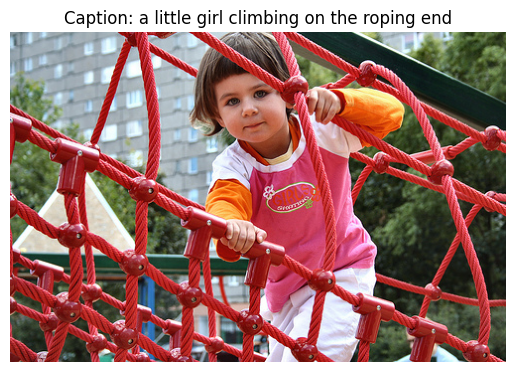

In [ ]:
test_image_id = list(features.keys())[5]
photo = features[test_image_id]


caption = generate_caption(model, tokenizer, photo, max_length)
print("Generated Caption:", caption)


import matplotlib.pyplot as plt
from PIL import Image

img_path = os.path.join(BASE_DIR, "Images", test_image_id + ".jpg")
image = Image.open(img_path)

plt.imshow(image)
plt.axis('off')
plt.title("Caption: " + caption)
plt.show()
